In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import numpy as np
import scipy

import influence.logistic_regression
import experiments
import experiments.counterexamples
from experiments.plot import *

from datasets.common import DataSet


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [305]:
config = { 'seed': 0, 'dataset_id': 'gauss2' }
E = experiments.counterexamples.Counterexamples(config)
E.run(force_refresh=True)

Experiment counterexamples: running gauss2
Results will be stored in /home/bbbert/influence/output/counterexamples/gauss2

Running phase 0-generate_datasets...
Phase 0-generate_datasets took 0.0046980381012 seconds

Running phase 1-training...
Training original model...
Train loss (w reg) on all data: 0.5279060330241918
Train loss (w/o reg) on all data: 0.5265201568603516
Test loss (w/o reg) on all data: 0.6809542655944825
Train acc on all data:  0.675
Test acc on all data:   0.625
Norm of the mean of gradients: 0.0025747207924723624
Norm of the params: 1.6648581
Training original model took 0.109788894653 seconds.
Individual loss computed: 40/40
Individual margin computed: 40/40
Accuracy computed: 40/40
Individual loss computed: 40/40
Individual margin computed: 40/40
Accuracy computed: 40/40
Computing gradients...
Gradients computed: 40/40
Margin gradients computed: 40/40
Gradients computed: 40/40
Margin gradients computed: 40/40
Computing gradients took 0.0237600803375 seconds.
Hess

In [311]:
E = experiments.counterexamples.Counterexamples.load_run('repeats')

Loading phase 0-generate_datasets from previous run:
/home/bbbert/influence/output/counterexamples/repeats/result_0-generate_datasets.npz
Loading phase 1-training from previous run:
/home/bbbert/influence/output/counterexamples/repeats/result_1-training.npz
Loading phase 2-find_newton_lt_pred from previous run:
/home/bbbert/influence/output/counterexamples/repeats/result_2-find_newton_lt_pred.npz
Loading phase 3-find_test_distribution from previous run:
/home/bbbert/influence/output/counterexamples/repeats/result_3-find_test_distribution.npz
Experiment counterexamples: run repeats results loaded in 0.0434169769287 seconds.



In [312]:
E.plot_all(True)

In [244]:
norm = np.linalg.norm(E.R['pred_dparams'], axis=1) * np.linalg.norm(E.R['newton_pred_dparams'])
cos = np.sum(E.R['pred_dparams'] * E.R['newton_pred_dparams'], axis=1) / (norm + 1e-3)
sizes = np.array([len(subset) for subset in E.R['subset_indices']])

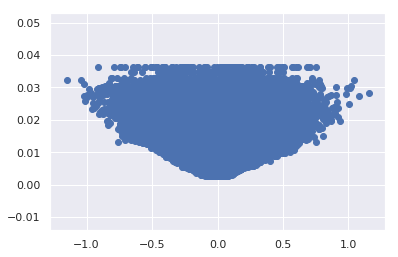

In [52]:
plt.scatter(E.R['subset_pred_margin_infl'].reshape(-1), np.repeat(cos, E.get_dataset().test.num_examples))

In [246]:
pairs = np.array([i for i, subset in enumerate(E.R['subset_indices']) if len(subset) == 2])
pairs.shape

(780,)

In [247]:
model = E.get_model()

Margin gradients computed: 2000/2000


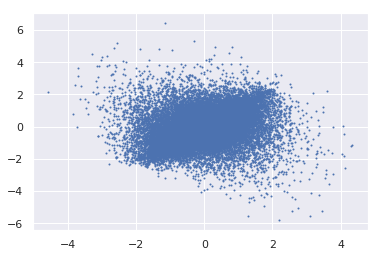

In [248]:
highest = np.argsort(cos)
D = E.R['pred_dparams'].shape[1]
O = 0
K = 20
X = []
for a, b in np.random.normal(0, 1, (2000, 2)):
    which = highest[O:O+K] ## overconstrained
    S = K
    which = np.random.choice(which, S, replace=False)
    A0 = E.R['pred_dparams'][which, :]
    A1 = E.R['newton_pred_dparams'][which, :]
    #A0 /= np.linalg.norm(A0, axis=1)
    #A1 /= np.linalg.norm(A1, axis=1)
    A = np.vstack([A0, A1])
    B = np.hstack([np.full(S, a), np.full(S, b)])
    X.append(np.linalg.lstsq(A, B, rcond=None)[0])
X = np.array(X)
Y = np.ones(X.shape[0])
ds = DataSet(X, Y) 

test_grad_margin = model.get_indiv_grad_margin(ds)

u = E.R['pred_dparams'][highest[O:O+K], :]
v = E.R['newton_pred_dparams'][highest[O:O+K], :]

pred = np.dot(test_grad_margin, u.T)
newton_pred = np.dot(test_grad_margin, v.T)
plt.scatter(pred.reshape(-1), newton_pred.reshape(-1), s=1)

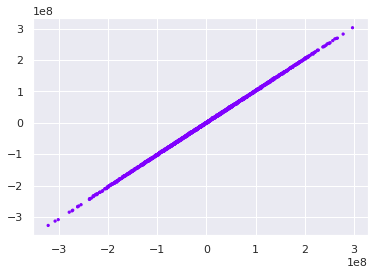

In [215]:
X = E.get_dataset().train.x
Y = E.get_dataset().train.labels
X = ds.x
Y = ds.labels
proj = np.random.normal(0, 1, (X.shape[1], 2))
XX = np.dot(X, proj)
plt.scatter(XX[:, 0], XX[:, 1], s=5, c=Y, cmap=plt.get_cmap('rainbow'))

In [125]:
np.linalg.norm(E.R['newton_pred_dparams'], axis=1)[:30]

array([0.15376229, 0.18406618, 0.1369784 , 0.19659888, 0.20308862,
       0.13681339, 0.12799629, 0.13687396, 0.18141362, 0.12964124,
       0.1999079 , 0.14581375, 0.32806332, 0.17199757, 0.12354701,
       0.15878347, 0.23680556, 0.15206649, 0.18978128, 0.17250729,
       0.25640585, 0.17513043, 0.12433759, 0.1726673 , 0.16163299,
       0.14527558, 0.12631059, 0.21010995, 0.17721102, 0.29324551])

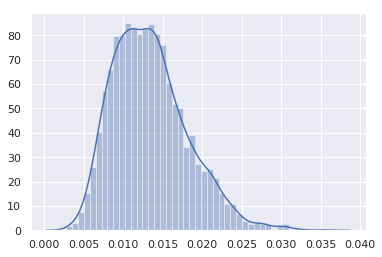

In [123]:
sns.distplot(cos)